In [2]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
import pandas as pd

#from rembg import remove

from config import *
from cropping import *
from landmarks_utils import *
from preprocessing import *
from face_landmarking_model import *
from training import *
from face_dataset import FaceDataset, EnsembleSampler
import itertools

In [3]:
# Prepare best groups for ensemble projection
groups = [os.path.basename(os.path.normpath(path_string)) for path_string in glob("./AI_Morphometrics/*/", recursive = False)]
groups_results = pd.read_json('training_results_means.json', orient='index')
groups_results.columns = ['result']
list_df = pd.read_csv('./preprocessed_data/path_list.txt', names=['text'], header=None)
counts = {}
for group in groups:
    counts[group] = len(list_df[list_df['text'].str.contains(group)])
compare = pd.concat([groups_results, pd.DataFrame(counts.items(), columns=['group', 'sample']).set_index('group')], axis = 1)
#plt.scatter(x=compare['sample'], y=compare['result'])

best_groups = compare.dropna().sort_values(by=['sample']).sort_values(by=['result']).index.to_list()

In [4]:
results = {}
valid_results = {}
cached_models = {}
times = {}
projectors = [1]
rotations = [True]
learning_rates = [0.01]
hidden_head_index = [3]
num_parents = [5]
ffn_bias = [False]

hyperparameter_combinations = list(itertools.product(projectors, rotations, learning_rates, num_parents, hidden_head_index, ffn_bias))
i = 0
for num_projectors, rotate, lr, num_parent_landmarks, hidden_head_index, ffn_bias in tqdm(hyperparameter_combinations):
    combination = f"{num_projectors}_{rotate}_{lr}_{num_parent_landmarks}_{hidden_head_index}_{ffn_bias}"
    model, optimizers, schedulers, datasets, dataloaders = prepare_trainers(best_groups, 
                                                                            num_parent_landmarks = num_parent_landmarks, 
                                                                            projectors=num_projectors, 
                                                                            rotate=rotate, 
                                                                            lr_projection=0.01,
                                                                            lr_cnn=0.01,
                                                                            lr_ffn=0.0001,
                                                                            hidden_head_index=hidden_head_index,
                                                                            ffn_bias=ffn_bias
                                                                            )

            

100%|██████████| 1/1 [00:22<00:00, 22.04s/it]


In [5]:
dataset = datasets['main']
dataset.work = False
dataset.pretraining = False
idx = torch.randint(dataset.__len__(),(1,))
print(idx)
batch = dataset.__getitem__(idx)
inputs, targets, multicrop = batch
print(multicrop.shape)

tensor([2192])
torch.Size([72, 48, 48])


In [6]:
# num_landmarks = 72
# a =  nn.Conv2d(num_landmarks * 8, num_landmarks * 16, groups = num_landmarks, kernel_size=5, stride=1, padding='same')
# a.out_channels

In [7]:
import torch
import torch.nn as nn

class MulticropAutoencoder(nn.Module):
    def __init__(self, num_landmarks, patch_height, patch_width, encoding_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(num_landmarks, num_landmarks * 32, groups = num_landmarks, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(num_landmarks * 32, num_landmarks * 8, groups = num_landmarks, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.linear_encoder = nn.Linear(num_landmarks * 144, encoding_dim * num_landmarks)
        self.linear_decoder = nn.Linear(encoding_dim * num_landmarks, num_landmarks * 144)
        
        mask_diag = torch.diag(torch.ones(num_landmarks))
        linear_encoder_mask = mask_diag.repeat_interleave(144, dim = 1).repeat_interleave(int(encoding_dim), dim = 0)
        # print(linear_encoder_mask.shape)
        # print(self.linear_encoder.weight.shape)
        self.register_buffer("mask", linear_encoder_mask)

        # Decoder
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(num_landmarks * 4, num_landmarks * 16, groups = num_landmarks, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(num_landmarks * 16, num_landmarks, groups = num_landmarks, kernel_size=3, stride=2),
        #     nn.Sigmoid()
        # )
        

        # self.encoder = torch.nn.Sequential(
        #     torch.nn.Conv2d(1 * num_landmarks, 32 * num_landmarks, 3, groups = num_landmarks, stride=1, padding=1),  # 
        #     torch.nn.ReLU(True),
        #     torch.nn.MaxPool2d(2, stride=1),
        #     torch.nn.Conv2d(32 * num_landmarks, 8 * num_landmarks, 3, groups = num_landmarks, stride=1, padding=1),  # b, 8, 3, 3
        #     torch.nn.ReLU(True),
        #     torch.nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        # )

        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.Conv2d(8 * num_landmarks, 32 * num_landmarks, 3, groups = num_landmarks, stride=1, padding=1),  # b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.Conv2d(32 * num_landmarks, 1 * num_landmarks, 3, groups = num_landmarks, stride=1, padding = 1),  # b, 8, 3, 3
            torch.nn.Sigmoid()
        )

    def forward(self, input_patches):
        # Reshape input_patches to (batch_size, num_landmarks * 3, patch_height, patch_width)
        # input_patches = input_patches.view(input_patches.size(0), -1, input_patches.size(3), input_patches.size(4))
        if input_patches.dim() < 4:
            input_patches = input_patches.unsqueeze(dim=0)
 
        # Encode each group of patches independently
        encoded_patches = self.encoder(input_patches)
        #print(encoded_patches.shape)
        # print(f'Encoded patch {encoded_patches.shape}')
        
        # flatten_convolutions = torch.flatten(encoded_patches, start_dim=-3)
        # # print(f'Encoded flatten {flatten_convolutions.shape}')
        
        # self.linear_encoder.weight.data.mul_(self.mask)
        # encoding = self.linear_encoder(flatten_convolutions)
        # #print(f'Encoding shape: {encoding.shape}')
        
        # self.linear_decoder.weight.data.mul_(self.mask.permute(1,0))
        # decoding = torch.unflatten(self.linear_decoder(encoding), -1, encoded_patches.shape[-3:])

        # Decode each group of patches independently
        # Decode directly from encoder????
        decoded_patches = self.decoder(encoded_patches)

        return decoded_patches

# Example usage
num_landmarks = 72
crop_size = CROP_SIZE
encoding_dim = 50

model = MulticropAutoencoder(num_landmarks, crop_size, crop_size, encoding_dim)

# Assuming input_patches is a tensor with shape (batch_size, num_landmarks * 3, patch_height, patch_width)
print(f'Input shape {multicrop.shape}')
output = model(multicrop)
output.shape


Input shape torch.Size([72, 48, 48])


torch.Size([1, 72, 48, 48])

In [8]:
model1 = MulticropAutoencoder(num_landmarks, crop_size, crop_size, encoding_dim)
model2 = MulticropAutoencoder(num_landmarks, crop_size, crop_size, encoding_dim)
num_epochs = 10  # Adjust based on your requirements
criterion1 = nn.MSELoss()  # Mean Squared Error loss for regression tasks
criterion2 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.005)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

model1.train()
model2.train()
# from torchmetrics.image import StructuralSimilarityIndexMeasure

# ssim = StructuralSimilarityIndexMeasure(data_range=255)
# ssim(preds, target)

loss1_cache = []
loss2_cache = []
loss3_cache = {'model1':[], 'model2':[]}

for epoch in range(num_epochs):

    for i, batch in enumerate(dataloader):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        x, y, multicrop = batch

        # Forward pass
        reconstruction1 = 255 * model1(multicrop/255)
        loss1 = criterion1(reconstruction1, multicrop)
        reconstruction2 = 255 * model2(multicrop/255)
        loss2 = criterion2(reconstruction2/255, multicrop/255)
        loss3 = criterion1(reconstruction2, multicrop)
        
        loss1_cache.append(loss1.item())
        loss1.backward()
        optimizer1.step()
        
        loss2_cache.append(loss2.item())
        loss2.backward()
        optimizer2.step()
        
        loss3_cache['model1'].append(loss1.item())
        loss3_cache['model2'].append(loss3.item())

        print(f'Epoch [{epoch},{i + 1}], Loss: {loss1.item()}, {loss3.item()}', end='\r')

KeyboardInterrupt: 

In [11]:
import plotly.graph_objs as go
fig = go.Figure()

scatter1 = go.Scatter(
    x=list(range(len(loss1_cache))),
    y=loss1_cache,
    mode='lines',
    name='model1',
    hovertext='model1'
    )
fig.add_trace(scatter1)

scatter2 = go.Scatter(
    x=list(range(len(loss3_cache['model2']))),
    y=loss3_cache['model2'],
    mode='lines',
    name='model2',
    hovertext='model2'
    )

fig.add_trace(scatter2)

fig.show()

In [13]:
result = model1(multicrop[:10])

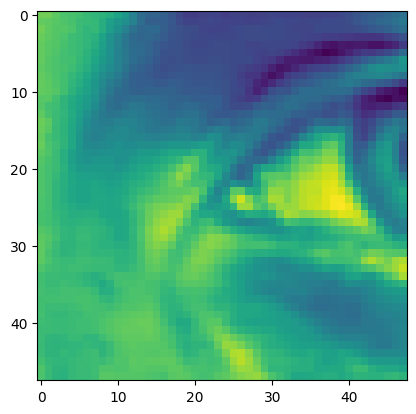

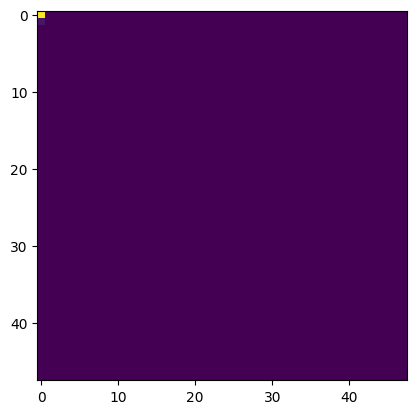

In [39]:
#num_landmark = 0
num_landmark += 1
plt.imshow(multicrop[0, num_landmark: num_landmark + 1, :,:].permute(1,2,0).type(torch.int))
plt.show()
plt.imshow(result[0, num_landmark: num_landmark + 1, :,:].permute(1,2,0).detach())
plt.show()

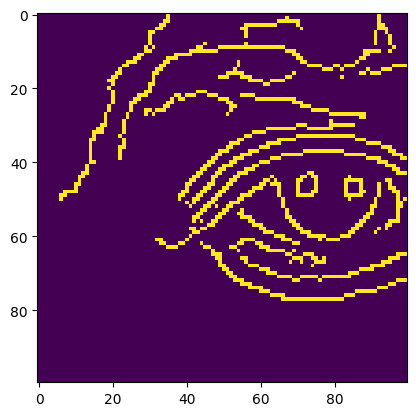

(100, 100)


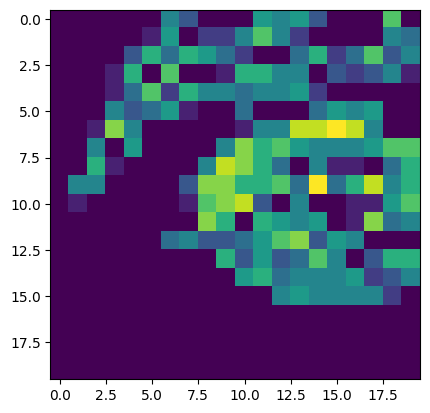

In [ ]:
edges = get_edges(crop)
plt.imshow(edges)
plt.show()
print(edges.shape)
m = nn.MaxPool2d(3, stride=3)
#avg_edges = m(torch.from_numpy(edges).unsqueeze(0)/255)
avg_edges = F.avg_pool2d(torch.from_numpy(edges).unsqueeze(0).unsqueeze(0)/255, kernel_size=5)
plt.imshow(avg_edges.squeeze().numpy()[:,:,None])
plt.show()

In [ ]:
def get_edges(image, threshold1=50, threshold2=150):
    img_blur = cv2.GaussianBlur(image, (3,3), 5) 
    edges = cv2.Canny(image=img_blur, threshold1=threshold1, threshold2=threshold2) 
    return edges
    


# sharpen_kernel = np.array([[-1, -1, -1],
#                            [-1, 9, -1],
#                            [-1, -1, -1]])  # Sharpening kernel
# sharpened_image = cv2.filter2D(crop, -1, sharpen_kernel)
# plt.imshow(sharpened_image)

landmark_num = 20

idx = torch.randint(dataset.__len__(),(1,))
print(idx)
#idx = 506
batch = dataset.__getitem__(idx)
inputs, targets, _, subimage, image = batch
y = targets.reshape(-1,2)

#display_landmarks(y[landmark_num:landmark_num+1,:], image, origin='upper_left')

# crop_pixel_center = [int(y[landmark_num,0].item() * image.shape[1]), int(y[landmark_num,1].item() * image.shape[0])]
# crop_size = 100
# crop = image[crop_pixel_center[1] - crop_size//2: crop_pixel_center[1] + crop_size//2, crop_pixel_center[0] - crop_size//2: crop_pixel_center[0] + crop_size//2,:]

img_blur = cv2.GaussianBlur(subimage, (3,3), 5) 
#plt.imshow(img_blur) 

# sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
# sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
# sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
# plt.imshow(sobelxy)
 
# #Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=50, threshold2=150) 
plt.imshow(edges)

image = edges.copy()

tensor([317])


ValueError: not enough values to unpack (expected 5, got 3)

In [ ]:
# making average multicrop
# preparation dataset
def get_avg_template(prep_dataset, template_size):
    multicrops = []
    for i in range(200):
        idx = torch.randint(prep_dataset.__len__(),(1,))
        batch = prep_dataset.__getitem__(idx)
        _, targets, _, subimage, image = batch
        img_blur = cv2.GaussianBlur(subimage, (3,3), 5) 
        edges = cv2.Canny(image=img_blur, threshold1=50, threshold2=150) 
        image = torch.from_numpy(edges).unsqueeze(-1)
        multicrop = make_landmark_crops(targets.reshape(1,-1), image, template_size)
        multicrops.append(multicrop)

    return torch.mean(torch.stack(multicrops, dim=0), dim=0)

avg_multicrop = get_avg_template(dataset, 30)


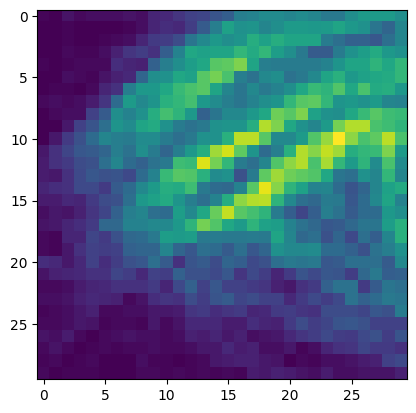

In [ ]:
plt.imshow(avg_multicrop[landmark_num,:,:])

In [ ]:
from cropping import make_landmark_crops
#image = torch.from_numpy(edges).unsqueeze(-1)
multicrop = make_landmark_crops(y.reshape(1,-1), image, 30)
num_landmark = 0


tensor([[0.5113, 0.1693, 0.4981, 0.7453, 0.4952, 0.6525, 0.5593, 0.6367, 0.4411,
         0.6346, 0.6181, 0.6154, 0.3870, 0.6101, 0.4934, 0.5881, 0.5220, 0.5829,
         0.4704, 0.5814, 0.5708, 0.5964, 0.4267, 0.5930, 0.4886, 0.5422, 0.5256,
         0.5207, 0.4535, 0.5201, 0.5731, 0.5233, 0.4195, 0.5220, 0.4335, 0.4894,
         0.5504, 0.4904, 0.4278, 0.4097, 0.3233, 0.3968, 0.3765, 0.3809, 0.3748,
         0.4092, 0.3533, 0.3894, 0.3982, 0.3898, 0.4115, 0.4117, 0.5706, 0.4098,
         0.6809, 0.3955, 0.6318, 0.4071, 0.6321, 0.3809, 0.6551, 0.3899, 0.6103,
         0.3895, 0.5951, 0.4079, 0.2599, 0.3591, 0.4422, 0.3542, 0.7521, 0.3558,
         0.5619, 0.3487, 0.5976, 0.3228, 0.6601, 0.3201, 0.7157, 0.3326, 0.6055,
         0.3360, 0.6559, 0.3320, 0.7088, 0.3412, 0.2929, 0.3321, 0.3515, 0.3228,
         0.4126, 0.3299, 0.3009, 0.3420, 0.3500, 0.3359, 0.4002, 0.3418, 0.2222,
         0.4352, 0.2325, 0.4800, 0.2413, 0.5270, 0.2489, 0.5740, 0.2578, 0.6188,
         0.2871, 0.6616, 0.3

UnboundLocalError: cannot access local variable 'multicrop' where it is not associated with a value

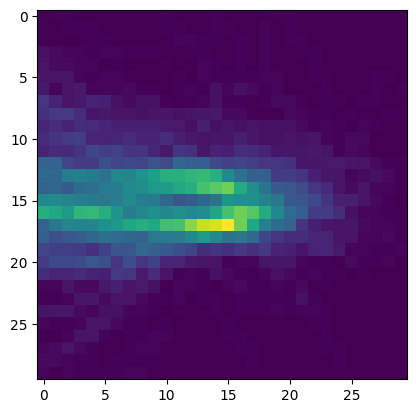

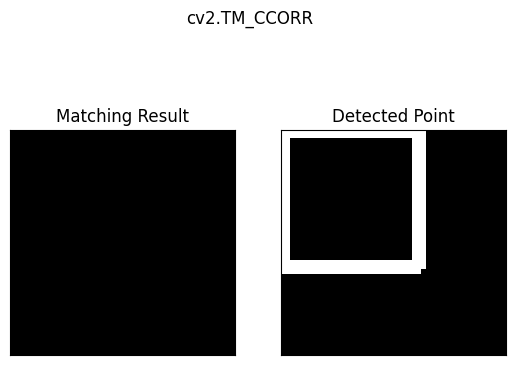

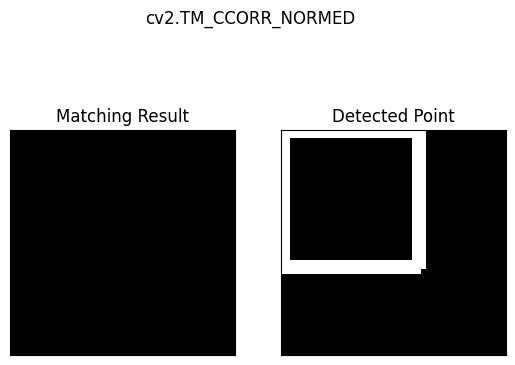

In [ ]:
#num_landmark=0
multicrop = avg_multicrop
channels = int(multicrop.shape[0]/72)
num_landmark+=1

landmarks = (int(y[num_landmark,0] * image.shape[1]), int(y[num_landmark,1] * image.shape[0]))

subimage = image[landmarks[1]-25 : landmarks[1]+25, landmarks[0]-25:landmarks[0]+25].astype(np.uint8)
landmark_pattern = multicrop[channels*num_landmark:channels*(num_landmark+1)].permute(1,2,0).squeeze().numpy().astype(np.uint8)

plt.imshow(landmark_pattern)
plt.show()
w, h = landmark_pattern.shape[1], landmark_pattern.shape[0]

methods = ['cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED']
for meth in methods:
    img = subimage.copy()
    method = eval(meth)
    # Apply template Matching
    template = landmark_pattern
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [ ]:
res.shape

(21, 21)

In [ ]:

def template_matching(image, landmarks, avg_template, crop_size = 50, template_method = None):
    method = eval(template_method)
    multicrop = make_landmark_crops(landmarks.reshape(1,-1), image, crop_size)
    crops = torch.split(multicrop, split_size_or_sections=1, dim=0)
    templates = torch.split(avg_template, split_size_or_sections=1, dim=0)
    matches = np.empty([1,0])

    for crop, template in zip(crops, templates):
        match = cv2.matchTemplate(crop, template, method)
        matches = np.concatenate([matches, match.reshape(1,-1)], axis= 1)
        
    return torch.from_numpy(matches).to(DEVICE)

In [ ]:
matching = np.empty([1,0])
matching 

array([], shape=(1, 0), dtype=float64)

In [ ]:
matching = np.concatenate([matching, res.reshape(1,-1)], axis= 1)
matching.shape

(1, 2205)

In [ ]:
import numpy as np
a = np.random.randn(72,50,50)
np.split(a, indices_or_sections=a.shape[-3], axis = 0)[0].shape

(1, 50, 50)

In [ ]:
a = np.random.randn(1,50,50)
a.squeeze().shape

(50, 50)

In [ ]:
a/255

array([[[ 5.65946858e-03,  2.45189645e-03,  7.29740426e-03, ...,
          6.10436344e-03,  1.92203460e-03,  3.86222723e-03],
        [ 4.96989841e-03,  1.62462688e-03, -2.36896074e-03, ...,
         -1.36104157e-03,  4.31562049e-04,  1.33176842e-03],
        [-2.46885923e-03, -4.18366181e-03,  3.06395765e-03, ...,
          1.16829861e-03, -3.87753975e-04,  5.35964640e-04],
        ...,
        [-2.90575505e-03, -3.54442885e-03, -7.39694657e-03, ...,
         -1.77515915e-03, -2.16126390e-03,  9.07595725e-05],
        [ 6.92978039e-03,  9.00776874e-04, -3.08878657e-03, ...,
          1.96419018e-03,  3.22857210e-03,  5.17854514e-03],
        [-4.68027773e-03, -4.00276969e-03, -3.35352690e-03, ...,
          2.54522072e-04,  8.86141244e-04, -2.13434246e-03]]])

In [ ]:
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import euclidean_distances
import cv2

from landmarks_utils import *
from cropping import *
from config import *
from face_landmarking_model import *
from face_dataset import *
from training import create_projection_mask, create_template_mask

num_parent_landmarks = 5 
projectors=1
rotate=True
lr_projection=0.01
lr_cnn=0.01
lr_ffn=0.01
hidden_head_index=2
ffn_bias=False
template_size=30
    
projection_mask = create_projection_mask(num_parent_landamrks=num_parent_landmarks)
template_mask = create_template_mask(template_size)    


model = FaceLandmarking(projection_mask, template_mask, projectors=projectors, hidden_head_index=hidden_head_index, ffn_bias=ffn_bias).to(DEVICE)
preparation_dataset = FaceDataset(model=model, rotate=rotate, subgroups=best_groups[:15])
avg_template = get_avg_template(preparation_dataset, template_size)
main_dataset = FaceDataset(model, rotate=rotate, avg_template=avg_template)

In [ ]:
main_dataset.pretraining = False
idx = torch.randint(main_dataset.__len__(),(1,))
print(idx)
#idx = 165

batch = main_dataset.__getitem__(idx)
inputs, targets, template= batch

tensor([207])


In [ ]:
templates = template.reshape(72,-1)
templates.shape

torch.Size([72, 441])

In [ ]:
templates = torch.split(template, split_size_or_sections=441, dim = 0)
len(templates)

72

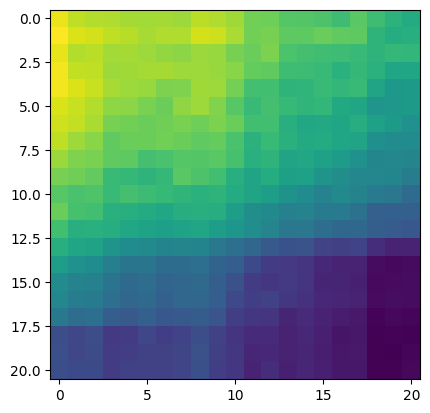

In [ ]:
plt.imshow(templates[20,:].reshape(21,21))